# General Imports
We need tensorflow, obviously, to learn things.

But these are also handy:
matplotlib (graph progress to see if you're training)
numpy (works well with the matrices)

In [1]:
import tensorflow as tf         
import matplotlib.pyplot as plt 
import numpy as np              
from random import sample 

# Importing MNIST
MNIST is a labelled dataset of handwritten characters. We're going to classify them. It has a special datatype. Don't worry about this bit, just copy-paste and we can get on to actually learning!
Also, use the paths to the MNIST files you downloaded. If you didn't download them, you can using a function or off their website.

In [2]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels

with open('train/train-images-idx3-ubyte.gz', 'rb') as _:
    train_images = extract_images(_)

with open('train/train-labels-idx1-ubyte.gz', 'rb') as _:
    train_labels = extract_labels(_)

with open('test/t10k-images-idx3-ubyte.gz', 'rb') as _:
    test_images = extract_images(_)

with open('test/t10k-labels-idx1-ubyte.gz', 'rb') as _:
    test_labels = extract_labels(_)

Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train/train-labels-idx1-ubyte.gz
Extracting test/t10k-images-idx3-ubyte.gz
Extracting test/t10k-labels-idx1-ubyte.gz


# Determining Data Shape
How exactly does our data look like, anyway?

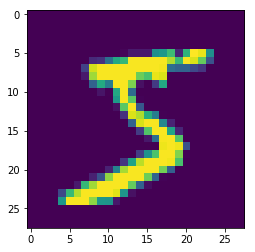

In [3]:
plt.imshow(np.squeeze(train_images[0]))
plt.show()

In [4]:
print(train_labels[0])

5


In [5]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28, 1)
(60000,)


# Placeholders and Sessions
Calling sess=tf.Session() automatically tells our program to put every operation, by default, in this "session" object. Don't worry about it for now.

A placeholder is a variable that you intend in giving a value later. For us, this will be our pictures, and our labels. We will also need to define the shape of this variable, i.e. the matrix shape of the variable. 
None represents a part of the variable with a shape which may be changed.

Pictures like these tend to be 4-dimensional input (a list of 3-dimensional inputs).

The first is batch size, how many images you have.
The second and third are x and y dimensions.
The fourth is the number of channels (in this case, 1: greyscale)

In [6]:
sess = tf.Session()
features = tf.placeholder(tf.float32, [None,28,28,1])
labels = tf.placeholder(tf.int32, [None])

# One-Hot Vectors
train_labels[0] == 5. That's the number we need, right?

Not really. Is incorrectly guessing that this number was 6 any different from incorrectly guessing that it was 1, when we're trying to classify it from handwriting? Not really. 

So, we need a way to show that each wrong answer is the same.
Enter the one-hot vector. 
[0,0,0,0,1,0,0,0,0,0]

This is saying that the probability that the number represented by the 5th axis here, is 1. This turns out to be much better in being able to classify it.


In [7]:
labels_one_hot = tf.one_hot(labels, 10)

# Convolutional Neural Network
It's basically magic that gives you the answer. Akil probably talked about it earlier.
It consists of:
Convolutional Layers 
- Filters: an integer. It literally applies some sort of filter.
- Kernel Size: a list of integers for every dimension. Tells the network to look for features around this size. 
- Activation Function: allows our neural net to learn nonlinearities.

Max Pooling 
- Pool Size 
- Stride
A fully connected layer at the end which gives you your final answer.

Here's a 4 hidden layer one. For each layer, you put the input as the previous layer (i.e. your first layer should be connected to inputs, then a max pooling to first, then second layer to max pooling of first layer, etc.)

Generally, more layers get better performance (up to a point!). You can add more layers, play with filters and kernel sizes and strides, whatever.

In [8]:
L0 = tf.layers.conv2d(inputs=features,filters =32, kernel_size = [3,3],padding = "same",activation = tf.nn.relu)
MP0 = tf.layers.max_pooling2d(inputs = L0, pool_size = [2,2],strides=1)
L1 = tf.layers.conv2d(inputs=MP0,filters =32, kernel_size = [3,3],padding = "same",activation = tf.nn.relu)
MP1 = tf.layers.max_pooling2d(inputs = L1, pool_size = [2,2],strides=1)
L2 = tf.layers.conv2d(inputs=MP1,filters =32, kernel_size = [3,3],padding = "same",activation = tf.nn.relu)
MP2 = tf.layers.max_pooling2d(inputs = L2, pool_size = [2,2],strides=1)
L3 = tf.layers.conv2d(inputs=MP2,filters =64, kernel_size = [3,3],padding = "same",activation = tf.nn.relu)
MP3 = tf.layers.max_pooling2d(inputs = L3, pool_size = [2,2],strides=2)
L4 = tf.layers.conv2d(inputs=MP3,filters =64, kernel_size = [3,3],padding = "same",activation = tf.nn.relu)
MP4 = tf.layers.max_pooling2d(inputs = L4, pool_size = [2,2],strides=2)

# The Dense Layer(s)
First, we need to flatten our inputs. The dense layer doesn't take 4 dimensional input, it takes 2 dimensional input (batch_size * something else).

To find the second parameter for flattening, we just need how many output nodes are in the last max pooling layer. Print out its shape and multiply them together.

The final layer will have the softmax activation function.
The outputs to each final node will be some number which describes how much the network thinks the output corresponding to the node is correct. 

You could take the maximum output across nodes to predict an answer, but this would be non-differentiable. So we take the SOFTmax, which gives us an answer which we can use to learn. Softmax also scales all outputs so that the total probability adds to 1, which is useful.

In [9]:
print(MP4.shape)

(?, 6, 6, 64)


In [10]:
flattened = tf.reshape(MP4, [-1,6*6*64])
D1 = tf.layers.dense(inputs=flattened,units=128,activation = tf.nn.relu)
output = tf.layers.dense(inputs = D1, units = 10, activation = tf.nn.softmax)


# Loss
There is a function called softmax cross entropy which works with one-hot labels. It's mathemagical, and you should use it for almost, if not all, your classification problems.


In [11]:
loss = tf.losses.softmax_cross_entropy(labels_one_hot, output)

# Optimizer
Calculus? That sounds hard! We don't need that in our life, let tensorflow do it for us. This function will automatically optimize all our variables to give us the best answer.

The parameter passed to optimizer here is learning rate. This determines how fast to learn. Bigger learning rates train more quickly, but might be unstable and not converge accurately. Smaller learning rates might take forever and get stuck in local optima. No one knows what the best one is. Play around and pick the best!

But, AdamOptimizer here makes picking one a bit of an easier task. So, I'll use this optimizer. There's quite a few.

In [12]:
opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Accuracy
Just so that we have an understanding of what is going on, we find how accurate our model is. (note this is not the best metric in every case)

tf.cast changes object types. It's necessary for two types to be the same for tf.math.equal to work (finds if each element in a matrix is the same on an element wise basis).

Casting correct to int32 casts all the True to 1 and all False to 0. Then, we can just add all the True and divide by how many samples we had.

In [13]:
prediction = tf.cast(tf.argmax(output, axis = 1),tf.int32)
correct = tf.cast(tf.math.equal(labels, prediction),tf.int32)
accuracy = tf.reduce_sum(correct)/tf.shape(features)[0]

global_variables_initializer initializes all the model parameters we were defining. Saver is to save the model.

While we're at it, sess.run(op, feed_dict = {...all placeholders})
tells Tensorflow to run the operation defined given all the placeholders. It won't do it until you ask it using this function. 

In [14]:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())


# Sampling
We should take a certain number of samples at a time, called a batch, and run them all at once. It's not a good idea to do one at a time, since it wastes Tensorflow's matrix math optimizations, or all at once, since it's easier to get stuck on local optima. Use whatever random sampling method you deem appropriate.

In [15]:
sample_nums = list(range(train_images.shape[0]))

# Can we finally train the model?
Yes.
You use sess.run(opt) to run the optimizer.
You can also feed a list of variables to have Tensorflow spit them all out.
We'll also be periodically printing losses and saving.

In [16]:
train_accs = []
for iteration in range(5000):
    ns = sample(sample_nums, 128)

    sample_features = np.take(train_images, ns,axis = 0)
    sample_labels = np.take(train_labels,ns,axis = 0)

    train_acc, train_loss,  __ = sess.run([accuracy, loss,opt], feed_dict = {features: sample_features, labels: sample_labels})


    if iteration % 100 == 0:
        print("Train loss " + str(train_loss))
        print("Train acc " + str(train_acc))
        train_accs.append(train_acc)

    if iteration % 1000 == 0:
        test_acc, test_loss = sess.run([accuracy,loss], feed_dict = {features: test_images, labels: test_labels})
        print("Test loss "+ str(test_loss))
        print("Test acc "+ str(test_acc))

        saver.save(sess, "models/mnist.ckpt")

Train loss 2.4063997
Train acc 0.0546875
Test loss 2.3137765
Test acc 0.1375
Train loss 1.9640471
Train acc 0.4921875
Train loss 1.994524
Train acc 0.4609375
Train loss 2.005371
Train acc 0.453125
Train loss 1.957352
Train acc 0.484375
Train loss 1.8961701
Train acc 0.5625
Train loss 2.015327
Train acc 0.4375
Train loss 1.856399
Train acc 0.59375
Train loss 1.7878623
Train acc 0.671875
Train loss 1.689649
Train acc 0.765625
Train loss 1.7141519
Train acc 0.75
Test loss 1.6622
Test acc 0.7973
Train loss 1.7004111
Train acc 0.7578125
Train loss 1.6451952
Train acc 0.8125
Train loss 1.6440145
Train acc 0.8125
Train loss 1.648711
Train acc 0.8046875
Train loss 1.653017
Train acc 0.8046875
Train loss 1.5661796
Train acc 0.8984375
Train loss 1.5124452
Train acc 0.953125
Train loss 1.5095018
Train acc 0.953125
Train loss 1.5383303
Train acc 0.921875
Train loss 1.5513408
Train acc 0.90625
Test loss 1.5629606
Test acc 0.8973
Train loss 1.5335971
Train acc 0.9296875
Train loss 1.5765204
Train ac

# Let's Graph Our Training Curve!

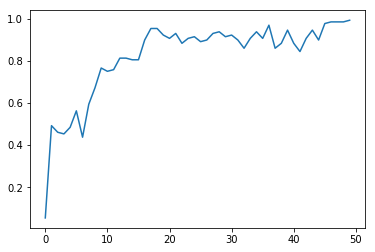

In [17]:
plt.plot(train_accs)
plt.show()

In [18]:
test_acc, test_loss = sess.run([accuracy,loss], feed_dict = {features: test_images, labels: test_labels})
print("Test loss "+ str(test_loss))
print("Test acc "+ str(test_acc))

Test loss 1.4722574
Test acc 0.9892


Not bad! Let's just see if our predictions make sense.

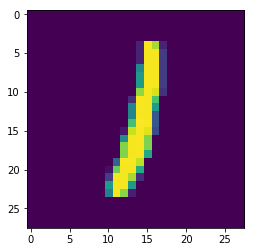

Class probs: [[5.8475114e-11 1.0000000e+00 3.1670699e-12 1.9041413e-12 1.8437048e-10
  2.1827485e-14 5.4176184e-13 1.8531036e-14 1.0464232e-11 1.4742148e-13]]
Numerical output: [1]


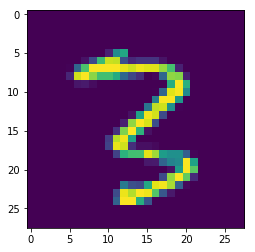

Class probs: [[2.4186117e-23 7.1137678e-23 1.5125427e-14 1.0000000e+00 6.9154446e-31
  7.4861979e-16 7.4537485e-29 2.8843563e-18 7.7484986e-18 1.8492679e-19]]
Numerical output: [3]


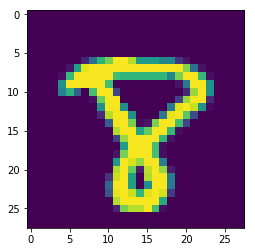

Class probs: [[1.5807175e-21 7.4513968e-27 1.3869993e-19 3.2889496e-20 2.1816299e-28
  1.4614277e-22 1.5008244e-28 1.0154104e-23 1.0000000e+00 5.1603346e-25]]
Numerical output: [8]


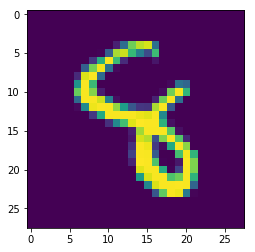

Class probs: [[2.1845502e-23 2.2280508e-10 3.0526945e-10 2.4900775e-18 2.8536473e-10
  3.9132569e-12 2.0629172e-15 3.6857211e-15 1.0000000e+00 3.1341926e-16]]
Numerical output: [8]


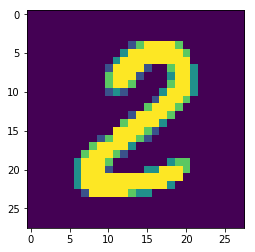

Class probs: [[6.4786306e-19 5.4458268e-25 1.0000000e+00 1.5903185e-18 6.7313990e-32
  1.4363224e-25 5.5996383e-30 7.1222068e-32 4.1445369e-15 3.5675298e-30]]
Numerical output: [2]


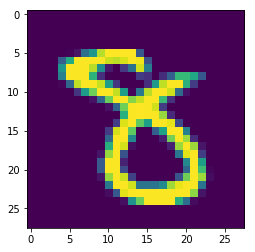

Class probs: [[2.6431965e-22 8.2215824e-21 3.8258351e-17 7.8264347e-14 2.3635155e-21
  2.0828009e-18 8.7607849e-20 1.5322593e-21 1.0000000e+00 3.1473590e-24]]
Numerical output: [8]


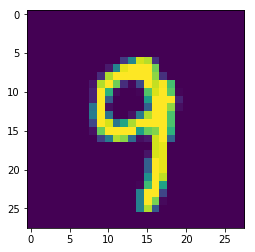

Class probs: [[3.3081825e-24 4.4731331e-22 1.4479654e-22 1.7828083e-15 3.0048017e-16
  2.9623624e-15 1.9680759e-28 6.8870773e-20 1.4214904e-18 1.0000000e+00]]
Numerical output: [9]


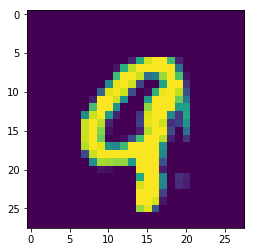

Class probs: [[2.7517799e-17 5.3544032e-19 2.7513258e-19 7.5402804e-16 5.4624300e-10
  2.5814934e-15 4.6545909e-21 2.3764915e-19 4.3498310e-18 1.0000000e+00]]
Numerical output: [9]


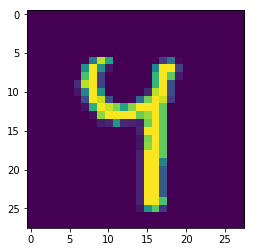

Class probs: [[2.0764387e-25 1.2047650e-12 8.3037527e-21 4.4134913e-20 9.9999988e-01
  9.1273636e-15 5.3665434e-21 4.6658605e-10 3.3549992e-14 6.8733137e-08]]
Numerical output: [4]


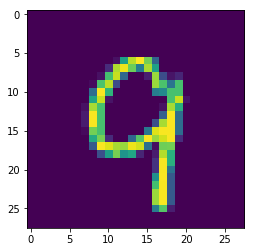

Class probs: [[1.0470903e-18 6.0010545e-22 3.2695244e-19 1.9034884e-15 4.6467635e-15
  2.0916948e-14 4.0130399e-23 2.0284781e-17 4.6829537e-17 1.0000000e+00]]
Numerical output: [9]


In [23]:
from random import randrange
for x in range(10):
    n = randrange(0,10000)
    plt.imshow(np.squeeze(test_images[n]))
    plt.show()

    out, pred = sess.run([output,prediction], feed_dict = {features: [test_images[n]]})
    print("Class probs: " + str(out))
    print("Numerical output: " + str(pred))

Pretty solid! We notice that the model thinks of the correct answer, with near 100% confidence.
Why isn't the test accuracy 100% then? There are probably ambiguous images in MNIST. Or, the model isn't trained well enough. But it seems pretty good!